# **Project Title: Multi-Source Intelligent Question Answering System Using LangGraph**
### **Primary Objective:**
To develop and implement an intelligent question-answering system that leverages LangGraph to dynamically route user queries to the most appropriate knowledge source (vector database, Wikipedia, or Google Search) for accurate and relevant responses.

### **Project Goal:**
To create a functional and reliable question-answering system capable of providing accurate and contextually relevant answers to user inquiries by intelligently selecting and querying appropriate information sources.

### **Project Procedure:**

**Phase 1: Environment Setup and Dependency Installation:**
Install necessary Python libraries (LangChain, LangGraph, vector database connectors, API wrappers, etc.).
Configure API keys and environment variables.
Setup the vector database and populate it with relevant data.

**Phase 2: Data Source Integration:**
Implement API wrappers for Wikipedia and Google Search.
Develop retrieval functions for the vector database.
Create data processing pipelines for each source (loading, chunking, embedding).

**Phase 3: LangGraph Workflow Development:**
Define the GraphState for managing the application's state.
Create nodes for data retrieval from each source (vector database, Wikipedia, Google Search).
Implement a routing function (route_question) to direct queries based on LLM analysis.
Construct the StateGraph with nodes and conditional edges.
Compile the workflow into an executable application.

**Phase 4: User Interface and Interaction:**
Develop an interactive command-line interface for user input.
Implement output formatting to display results and source attribution.
Add error handling and user feedback mechanisms.

**Phase 5: Testing and Evaluation:**
Test the system with a variety of questions to assess accuracy and performance.
Evaluate the routing logic and data source selection.
Refine the system based on testing results.

**Phase 6: Visualization:**
Implement the mermaid graph visualization.

### **Conclusion:**

This project successfully demonstrates the implementation of a multi-source intelligent question-answering system using LangGraph.
The system effectively routes user queries to the most relevant data source, providing accurate and comprehensive answers.
The modular design allows for easy expansion and integration of additional data sources.
The interactive interface enhances user experience and facilitates effective knowledge retrieval.
The project highlights the potential of LangGraph for building sophisticated LLM-powered applications.


# **Environment Setup:**

### Understanding the Installations:


* `langchain`: The core framework for building LLM applications.
* `langgraph`: For creating stateful,
multi-actor applications with LLMs.
* `cassio`: Integrates with Cassandra/Astra DB for vector storage and data management.
* `tiktoken`: OpenAI's fast BPE tokeniser, essential for token counting.
* `langchain_community`: Community contributed tools and integrations for Langchain.
* `langchain-groq`: Enables integration with the Groq LLM API.
* `langchainhub`: Provides access to pre-built LangChain components.

* `chromadb`: A popular in-memory vector database.

* `langchain_huggingface`: Integrates with Hugging Face models

* `google-api-python-client`: Allows access to Google

* `langchain-google-community`: Integrations for google models and services
*` arxiv`: For fetching papers from arXiv.
*` wikipedia`: For accessing Wikipedia data.








In [129]:
!pip install langchain langgraph cassio tiktoken langchain_community
!pip install -U langchain-groq langchainhub chromadb langchain_huggingface
!pip install google-api-python-client arxiv wikipedia langchain-google-community

# **Installing Required Packages**

In [130]:
import os
import cassio

from typing import List

from pprint import pprint

from typing import Literal

from google.colab import userdata

from langchain_groq import ChatGroq

from typing_extensions import TypedDict
from langchain.schema import Document

from IPython.display import Image, display

from langchain_core.documents import Document

from langgraph.graph import END, StateGraph, START

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores.cassandra import Cassandra

from langchain.indexes.vectorstore import VectorStoreIndexWrapper

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper,GoogleSearchAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun,GoogleSearchRun




# **Connecting to AstraDB for Vector Storage**

In [131]:
DATABASE_TOKEN = userdata.get("DATABASE_TOKEN")
DATABASE_ID = userdata.get("DATABASE_ID")
cassio.init(token=DATABASE_TOKEN,database_id=DATABASE_ID)


#  **URLs for Content Extractiont**

In [132]:
#urls contain information about "agents","prompt-engineering","llms-attack"
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# **Loading and Chunking Web Content**

In [133]:
# load the url

docs=[WebBaseLoader(urls).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]
print(f"loaded {len(doc_list)} documents")
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
texts = text_splitter.split_documents(doc_list)

docs_split = text_splitter.split_documents(doc_list)
print("docs_split",docs_split)


loaded 9 documents
docs_split [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby impro

# **Creating Hugging Face Embeddings Instance**

In [134]:
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# **AstraDB Vector Store Initialization**

In [135]:
astra_vector_store = Cassandra(
    embedding=embeddings,
    session=None,
    keyspace=None,
    table_name="qa_demo",
)
astra_vector_store.add_documents(docs_split)
print("Inserted %i headlines." % len(docs_split))
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 135 headlines.


In [136]:
retriever=astra_vector_store.as_retriever()
retriever.invoke("What is cool concept",ConsistencyLevel="LOCAL_ONE",)

[Document(id='41c01472deac43a8af5efed93f3faf6b', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

# **Groq LLM Question Routing**

In [137]:
### Router

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search","google_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or vectorstore or google.",
    )

groq_api_key=userdata.get('GROQ_API')
os.environ["GROQ_API_KEY"]=groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama-3.3-70b-versatile")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia or google .
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search or google search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(question_router.invoke({"question": "who is Sharukh Khan?"}),"1")
print(question_router.invoke({"question": "What are the types of agent memory?"}),"2")
print(question_router.invoke({"question": "What is oops"}),"3")

datasource='wiki_search' 1
datasource='vectorstore' 2
datasource='google_search' 3


# **Google API Environment Configuration**

In [138]:
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API')
os.environ["GOOGLE_CSE_ID"] = userdata.get("GOOGLE_CSE_ID")

# **Initializing External Search Tools**

In [139]:
### Working With Tools

## Arxiv Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

# wikipedia Tools
api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=2000)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

# Google Search Tool
google_search_wrapper = GoogleSearchAPIWrapper()
google = GoogleSearchRun(api_wrapper=google_search_wrapper)

In [140]:
wiki.run("tell me about sharukh khan")

'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), also known by the initialism SRK, is an Indian actor and film producer who works in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 100 films, and earned numerous accolades, including 14 Filmfare Awards. He has been awarded the Padma Shri by the Government of India, as well as the Order of Arts and Letters and Legion of Honour by the Government of France. Khan has a significant following in Asia and the Indian diaspora worldwide. In terms of audience size and income, several media outlets have described him as one of the most successful film stars in the world. Many of his films thematise Indian national identity and connections with diaspora communities, or gender, racial, social and religious differences and grievances.\nKhan began his career with appearances in several television series in the late 1980s and made his 

In [141]:
google.run("what is oops?")

"OOP focuses on the objects that developers want to manipulate rather than the logic required to manipulate them. This approach to programming is well suited for\xa0... Feb 9, 2023 ... Object-oriented programming aims to implement real-world entities like inheritance, hiding, polymorphism, etc in programming. The main aim of\xa0... Many of the most widely used programming languages (such as C++, Java, and Python) are multi-paradigm and support object-oriented programming to a greater or\xa0... OOP stands for Object-Oriented Programming. Procedural programming is about writing procedures or methods that perform operations on the data. WHAT IS AN OPT-OUT PREFERENCE. SIGNAL (OOPS)?. An OOPS is a simple and easy-to-use way for consumers to automatically exercise. May 1, 2022 ... Object-oriented programming is a style of programming that involves lumping data and actions into objects that can be acted on like any\xa0... Oct 4, 2022 ... Object-oriented programming (OOP) is defined as a progr

# **Creating GraphState for LangGraph**

In [142]:
## Graph
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

# **Document Retrieval Function**

In [143]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

# **Wikipedia Query and Document Creation**

In [144]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

# **Google Search and Result Integration**

In [145]:
def google_search(state):
    """
    Google search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    question = state["question"]
    print(question)

    try:
        # Google search
        search_results = google.invoke({"query": question})

        # Create a Document object with the search results
        document = Document(page_content=search_results)

        # Return a dictionary with the Document object
        return {"documents": [document], "question": question}  # Return a list of documents

    except Exception as e:
        print(f"Error during Google search: {e}")
        return {"documents": [], "question": question}  # Return empty list on error

# **Routing Question to Data Source**

In [146]:
### Edges ###
def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        return "wiki_search"
    elif source.datasource == "vectorstore":
        return "vectorstore"
    elif source.datasource == "google_search":
        return "google_search"

# **Workflow Constructionn**

In [147]:
workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("google_search", google_search)  # google search
# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
        "google_search": "google_search",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
workflow.add_edge( "google_search", END)
# Compile
app = workflow.compile()

# **LangGraph Workflow Visualization**

Displaying LangGraph Workflow Visualization (Mermaid):


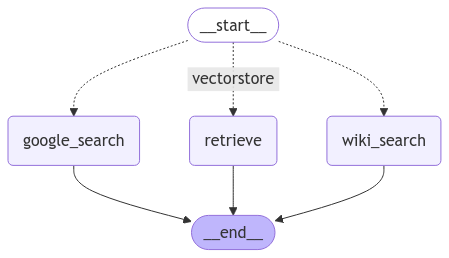

In [148]:
try:
    print("Displaying LangGraph Workflow Visualization (Mermaid):")
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# **Run LangGraph Application**

In [ ]:
def run_interactive_question_answering(app):
    """
    Executes an interactive question-answering session using the provided LangGraph application.

    Args:
        app: The compiled LangGraph application.
    """
    try:
        while True:
            question = input("Enter your question (or type 'exit' to terminate): ").strip()
            if question.lower() == "exit":
                print("Exiting the interactive session.")
                break

            inputs = {"question": question}
            for output in app.stream(inputs):
                for node_name, node_output in output.items():
                    if node_name == "retrieve":
                        print("Source: Vector Store")
                        if node_output['documents']:
                            pprint(node_output['documents'][0].dict()['metadata']['description'])
                        else:
                            print("No results found in vector store.")
                    elif node_name == "wiki_search":
                        print("Source: Wikipedia Search")
                        if node_output['documents']:
                            pprint(node_output['documents'].page_content)
                        else:
                            print("No results found in Wikipedia.")
                    elif node_name == "google_search":
                        print("Source: Google Search")
                        if node_output['documents']:
                            pprint(node_output['documents'][0].page_content)
                        else:
                            print("No results found in Google Search.")
            print()


    except KeyboardInterrupt:
        print("\nInteractive session interrupted by user.")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
    finally:
        print("Session terminated.")

run_interactive_question_answering(app)